## Test run
This notebook is succinct version of `styphimurium.ipynb`. This notebook is intended to test `RIBOSS` and reproduce the key results.

#### Follow README to create `conda` environment and clone the `RIBOSS` repository if you haven't already done so.
```
cd riboss
```

#### Visit [Zenodo](https://doi.org/10.5281/zenodo.13997374) and download the BAM files
```
mv D23005*.bam doc/styphimurium/rnaseq
mkdir doc/styphimurium/riboseq
mv ERR913094*.out.bam doc/styphimurium/riboseq
```

#### Assemble transcriptome by combining PacBio long-read and Illumina short-read RNA-seq data (strain D23005)

In [1]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = 'ref/NC_003197.1.fasta'
short_reads = 'doc/styphimurium/rnaseq/D23005.sorted.bam' 
long_reads = 'doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bam'
strandness = 'rf'

tx_assembly, gtf = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness)

INFO:root:saved StringTie GTF as doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.gtf
INFO:root:converted transcriptome assembly to doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.bed
INFO:root:extracted sequences to doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.fa


#### Predict operons from transcriptome assembly

finding all ORFs       : 100%|██████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 208it/s]
INFO:root:plotted the distribution of operons as results/operon_finder/D23005-sc-1962750.operon_dist.pdf and results/operon_finder/D23005-sc-1962750.operon_scatter.pdf
INFO:root:saved operons and ORFs as results/operon_finder/D23005-sc-1962750.operon_finder.pkl.gz
INFO:root:saved CDS range as results/operon_finder/D23005-sc-1962750.cds_range.txt


ORF_type
oORF     30991
sORF     27498
mORF       899
opORF      577
Name: count, dtype: int64

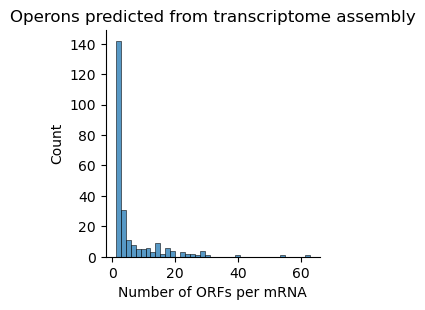

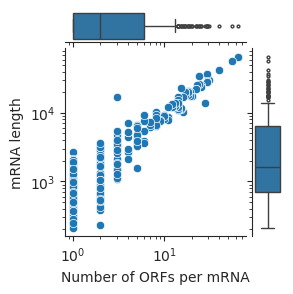

In [1]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed = 'ref/NC_003197.2.bed'
outdir = 'results/operon_finder'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
delim = '::'

cds_range, df = operon_finder(tx_assembly, bed, outdir, delim)
df.value_counts('ORF_type')

#### Analyse ribosome footprints

analyse_footprints allows the aligned footprint positions to be adjusted to the P-site, either from the 5' or 3' end through the offset_method. For this data, the 5' offset method produced more consistent triplet periodicity for the footprint sizes 25 nt and 28 nt (see metagene plots).

downsampling BAM       : 4944612it [00:07, 664725.68it/s]
comparing periodicity  : 100%|███████████████████████████████████████████████████████| 11.0/11.0 [00:02<00:00, 3.96it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 12595789it [00:18, 685529.93it/s]
comparing periodicity  : 100%|███████████████████████████████████████████████████████| 11.0/11.0 [00:06<00:00, 1.64it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130943Aligned.out.frames.pdf
INFO:root:save

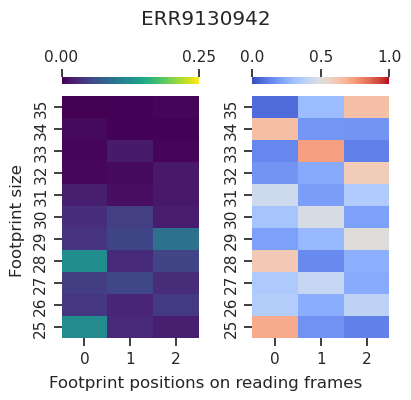

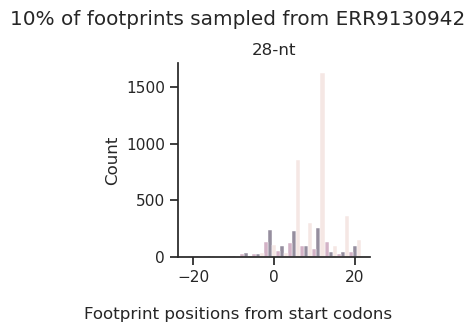

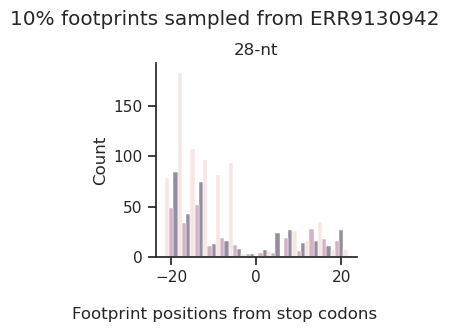

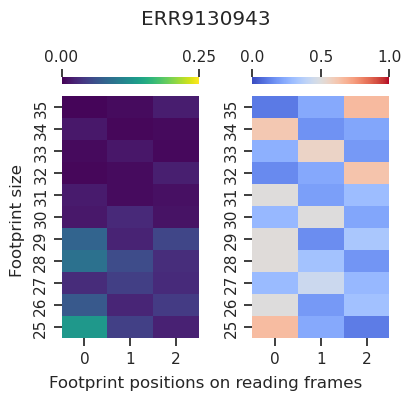

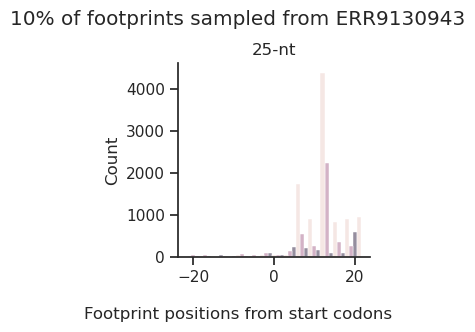

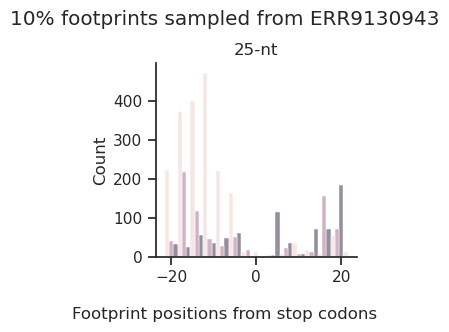

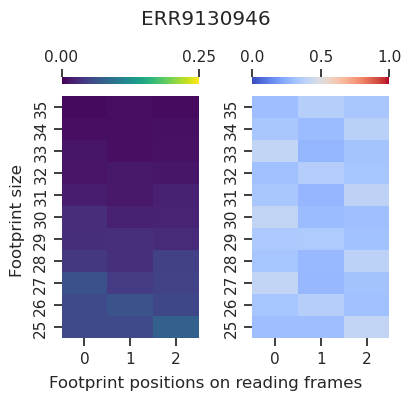

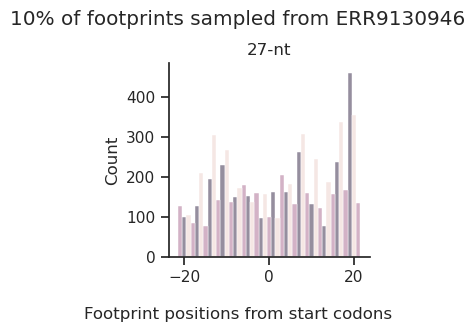

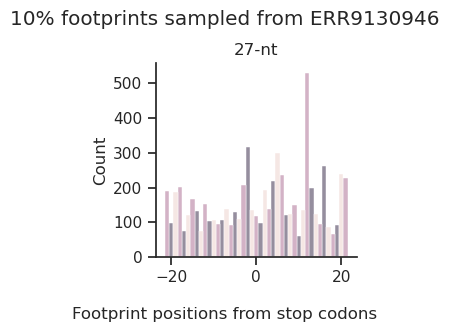

In [2]:
from riboss.footprints import analyse_footprints
from glob import glob

offset_method = '5p'
adj = 12
downsampling = 0.1
outdir = 'results/analyse_footprints'

for i in glob('doc/styphimurium/riboseq/*[!4|!5]Aligned.out.bam'):
    _ = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'best', outdir)

#### Merge ribosome profiling data and footprint offset files

In [4]:
! samtools merge \
    doc/styphimurium/riboseq/ERR9130942Aligned.out.bam \
    doc/styphimurium/riboseq/ERR9130943Aligned.out.bam \
    -f -o doc/styphimurium/riboseq/ERR9130942_3.bam

! cat results/analyse_footprints/ERR9130943Aligned.out.offset.txt \
    results/analyse_footprints/ERR9130942Aligned.out.offset.txt > \
    results/analyse_footprints/offset.txt

#### Build salmon index using transcriptome assembly and run salmon quant

In [4]:
from riboss.wrapper import quantify_transcripts

index = 'doc/styphimurium/rnaseq/D23005-sc-1962750'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
rnaseq = 'doc/styphimurium/riboseq/ERR9130946.fastq.gz'

quantify_transcripts(rnaseq, tx_assembly, index)

Version Server Response: Not Found
index ["doc/styphimurium/rnaseq/D23005-sc-1962750_puff"] did not previously exist  . . . creating it
[2024-10-29 13:30:56.845] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-10-29 13:30:56.845] [jLog] [info] building index
out : doc/styphimurium/rnaseq/D23005-sc-1962750_puff
[2024-10-29 13:30:56.847] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-10-29 13:30:56.888] [puff::index::jointLog] [info] Replaced 0 non-ATCG nucleotides
[2024-10-29 13:30:56.888] [puff::index::jointLog] [info] Clipped poly-A tails from 0 transcripts
wrote 256 cleaned references
[2024-10-29 13:30:56.905] [puff::index::jointLog] [i

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 33554432
Capacity = 2
Files: 
doc/styphimurium/rnaseq/D23005-sc-1962750_puff/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:33554432
Pass	Filling	Filtering
1	1	0	
2	0	0
True junctions count = 119
False junctions count = 2672
Hash table size = 2791
Candidate marks count = 2952
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 770
Edges construction time: 0
--------------------------------------------------------------------------------
Distinct junctions = 119



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 42
Max Junction ID: 658
seen.size():5273 kmerInfo.size():659
approximateContigTotalLength: 1287910
counters for complex kmers:
(prec>1 & succ>1)=14 | (succ>1 & isStart)=0 | (prec>1 & isEnd)=1 | (isStart & isEnd)=0
contig count: 435 element count: 1409613 complex nodes: 15
# of ones in rank vector: 434
[2024-10-29 13:30:57.316] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-10-29 13:30:57.316] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory doc/styphimurium/rnaseq/D23005-sc-1962750_puff
size = 1409613
-----------------------------------------
| Loading contigs | Time = 1.5087 ms
-----------------------------------------
size = 1409613
-----------------------------------------
| Loading contig boundaries | Time = 1.3108 ms
--------------------

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray         7323648  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


-----------------------------------------
| Loading contig table | Time = 1.009 ms
-----------------------------------------
size = 435
-----------------------------------------
| Loading contig offsets | Time = 1.0089 ms
-----------------------------------------
-----------------------------------------
| Loading reference lengths | Time = 3.076 us
-----------------------------------------
-----------------------------------------
| Loading mphf table | Time = 931.23 us
-----------------------------------------
size = 1409613
Number of ones: 434
Number of ones per inventory item: 512
Inventory entries filled: 1
-----------------------------------------
| Loading contig boundaries | Time = 2.5363 ms
-----------------------------------------
size = 1409613
-----------------------------------------
| Loading sequence | Time = 1.13 ms
-----------------------------------------
size = 1396593
-----------------------------------------
| Loading positions | Time = 6.1035 ms
------------------

#### Run riboprof (ribomap)

In [1]:
from riboss.wrapper import riboprofiler

offset = 'results/analyse_footprints/offset.txt'
ribobam = 'doc/styphimurium/riboseq/ERR9130942_3.bam'
mrnabam = 'doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
sf = 'doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out = 'results/riboprofiler/ERR9130942_3'
cds_range_file = 'results/operon_finder/D23005-sc-1962750.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx_assembly, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 256
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 253
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 10486879
getting read type and p-sites...
total output footprint: 10486879
total: 10486879	multi_mapped: 101467 (0.97 %)
assigning reads to frame 0 loci...
reads used: 1563729 reads assigned: 1563729
assigning reads to frame 1 and 2 loci...
reads used: 2348772 reads assigned: 2348772
assigning reads to UTR loci...
reads used: 4078426 reads assigned: 4078426
assigning RNA-seq reads...
number of transcripts in profile class: 253
loading reads from bam...
getting alignment records...
total number of reads: 10778748
getting read type and p-sites...
total output footprint: 10778748
total: 10778748	multi_mapped: 185177 (1.72 %)
assigning reads...
reads used: 10778748 reads assigned: 10778748
writ

INFO:root:saved main output as results/riboprofiler/ERR9130942_3.base


#### Find new ORFs using the main RIBOSS function

parsing ribomap output : 100%|███████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 2.37kit/s]
INFO:root:saved ribosome profiles as results/riboss/ERR9130942_3.riboprof.plus.bg and results/riboss/ERR9130942_3.riboprof.minus.bg
counting footprints    : 100%|████████████████████████████████████████████████████████████████████████████████████| 59.8k/59.8k [00:00<00:00, 113kit/s]
comparing periodicity  : 100%|████████████████████████████████████████████████████████████████████████████████████| 9.71k/9.71k [24:11<00:00, 6.69it/s]
INFO:root:saved RIBOSS stats as results/riboss/ERR9130942_3.riboss.csv and results/riboss/ERR9130942_3.riboss.json
INFO:root:saved significant RIBOSS results (n=290) as results/riboss/ERR9130942_3.riboss.sig.csv, results/riboss/ERR9130942_3.riboss.sig.json, and results/riboss/ERR9130942_3.riboss.sig.bed
INFO:root:perform BLASTP for RIBOSS hits (n=290)
INFO:root:finished BLASTP in 2 min 3 s
INFO:root:saved BLA

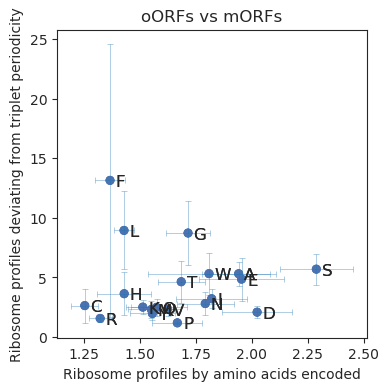

INFO:root:saved scatterplot for anomaly ribosome profiles as results/riboss/ERR9130942_3.riboss.riboprof_aa.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved BLASTP results for RIBOSS hits as results/riboss/ERR9130942_3.riboss.tophits.pkl.gz, results/riboss/ERR9130942_3.riboss.sig.blastp.csv, results/riboss/ERR9130942_3.riboss.sig.blastp.json, and results/riboss/ERR9130942_3.riboss.sig.blastp.pkl.g

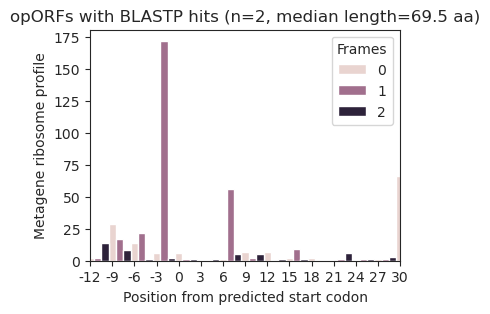

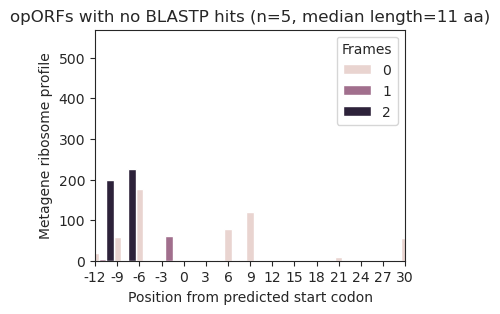

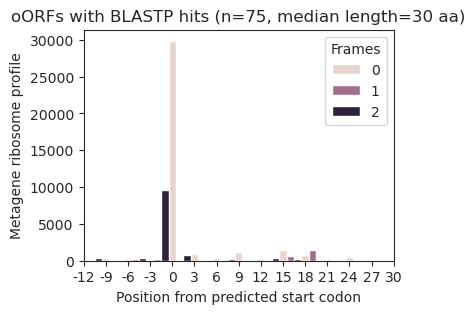

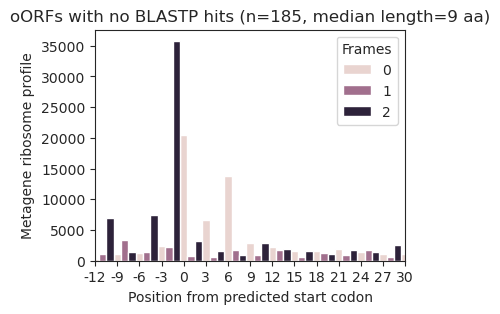

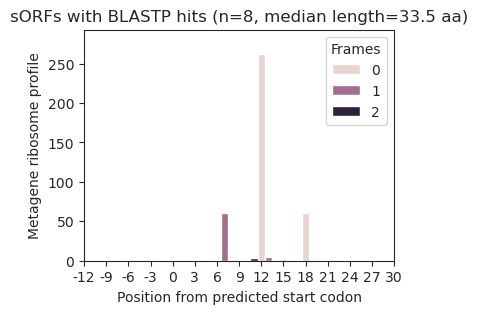

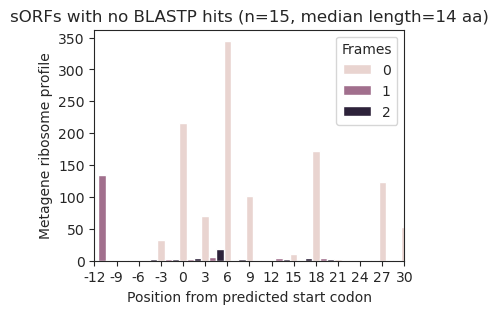

In [3]:
from riboss.riboss import riboss
import pandas as pd

riboprof_base = 'results/riboprofiler/ERR9130942_3.base'
tx_assembly = 'doc/styphimurium/rnaseq/D23005-sc-1962750.fa'
fasta = 'ref/GCF_000006945.2_ASM694v2_genomic.fna'
fai = 'ref/GCF_000006945.2_ASM694v2_genomic.fna.fai'
bed = 'ref/NC_003197.2.bed'
superkingdom='Bacteria'
outdir = 'results/riboss'
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'

ipg, tophits, blast, sig, boss_df = riboss(superkingdom, df, riboprof_base, tx_assembly, fasta, fai, bed,
                                           tie=False, 
                                           run_blastp=True, run_efetch=True, 
                                           email=email, api_key=api_key, 
                                           delim='::',
                                           outdir=outdir)

#### Visit the [_S_. Typhimurium LT2 genome](https://genome.ucsc.edu/h/GCF_000006945.2) at the UCSC Genome Browser
Click "Manage custom tracks" and submit the tracks below using "Paste URLs or Data".

1. BigGenePred annotation track for predicted sORFs:
```
track type=bigGenePred name="sORFs" description="RIBOSS top hits" baseColorDefault=genomicCodons bigDataUrl=https://github.com/lcscs12345/riboss/raw/refs/heads/master/results/riboss/ERR9130942_3.riboss.sORF.tophits.bb
```

2. BedGraph for ribosome profiles:
```
https://raw.githubusercontent.com/lcscs12345/riboss/refs/heads/master/results/riboss/ERR9130942_3.riboprof.bg
```

3. BED annotation track for transcriptome assembly:
```
https://github.com/lcscs12345/riboss/raw/refs/heads/master/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```